In [1]:
import os, sys, pickle

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
import scipy, math
from scipy import stats
import jp_mpl as jplot

import ntuple_tools
reload(ntuple_tools)

TClass::TClass:0: RuntimeWarning: no dictionary for class omtext is available


<module 'ntuple_tools' from '/home/jpyanez/snoplus/snoplus_python/ntuple_tools.pyc'>

In [2]:
import ROOT
import rat

In [50]:
basedir = '/home/jpyanez/scratch/snoplus/full_ntuples/n16_2017'
#filename = 'Calibration_r0000107074_s000_p001.ntuple.root'
filename = 'Calibration_r0000107071_s000_p001.ntuple.root' # center
#filename = 'Calibration_r0000107064_s000_p001.ntuple.root' # 2m out in y

#basedir = '/home/jpyanez/scratch/snoplus/full_ntuples/n16_2017_mc'
#filename = 'WaterN16sourceRun_r106948_s0_p14.ntuple.root'
#filename = 'WaterN16sourceRun_r106946_s0_p17.ntuple.root'
#filename = 'WaterN16sourceRun_r106944_s0_p13.ntuple.root'

In [51]:
tfile = ROOT.TFile(os.path.join(basedir, filename))

In [52]:
def getArray(tfile, branch_name):
    if branch_name == 'energy':
        print 'Using RSP energy correction'
        rc = rat.utility().GetReconCorrector().Get()
        print 'Test RSP correction', rc.CorrectEnergyRSP(5.0)
    
    tree = tfile.Get('output')
    branch = tree.GetBranch(branch_name)
    tot_entries = branch.GetEntries()

    values = np.zeros(tot_entries)
    counter = 0
    # Special loop for energy to avoid doing many ifs
    if branch_name == 'energy':
        None
        for i in range(tot_entries):
            branch.GetEntry(i)
            values[counter] = rc.CorrectEnergyRSP(branch.GetLeaf(branch_name).GetValue(0))
            counter += 1
    else:
        for i in range(tot_entries):
            branch.GetEntry(i)
            values[counter] = branch.GetLeaf(branch_name).GetValue(0)
            counter += 1
    return values
    

In [53]:
var_names =['qpdtProbability',
            'qpdtNhitsEarly',
            'nhitsCleaned',
            'itr',
            'energy',
            'beta14',
            'fitValid',
            'triggerWord',
            'qpdtQMax',
            'isCal',
            'posr']
if 'Calibration' in filename:
    var_names += ['dcApplied',  'dcFlagged']

In [54]:
mc_data = {}
for one_var in var_names:
    mc_data[one_var] = getArray(tfile, one_var)

Using RSP energy correction
Test RSP correction 5.0004091635


In [55]:
data_sitr = (0.74-mc_data['itr'])*np.sqrt(mc_data['nhitsCleaned'])/0.43

In [56]:
# Plots
my_keys = [['qpdtProbability', [0,1]],
           ['qpdtNhitsEarly', [0,20]],
           ['qpdtQMax', [0,200]],
           ['nhitsCleaned', [0,50]],
           ['itr', [0,1]],
           ['energy', [2.2, 9]],
           ['beta14', [0,1]],
           ['posr', [0, 8300]]
           ]

#for one_key, axlim in my_keys:
#    ntuple_tools.arrayDiagnostics(mc_data[one_key], one_key,ax_lim=axlim)


In [57]:
xenergy = np.linspace(3.25, 4, 12)
xcenergy = (xenergy[1:] + xenergy[:-1])/2.
xbeta14 = np.linspace(-0.12,0.95, 12)
xradius = np.linspace(0, .8, 12)
rav = 6000.


In [58]:
if 'Calibration' in filename:
    mask_cut = np.zeros_like(mc_data['energy'], dtype=bool)
    for i in range(mask_cut.size):
        mask_cut[i] = (((int(mc_data['dcApplied'][i]) & 0x10000017FFE) & int(mc_data['dcFlagged'][i])) == 
                       (int(mc_data['dcApplied'][i]) & 0x10000017FFE))
    print np.sum(mask_cut)*1./mask_cut.size

0.563518741251


In [66]:
qpdt_prob_scale = 0.0143
qpdtqmax = 200.

In [67]:
data_cuts = (
       (mc_data['energy']>3.) *
       #(all_pmt['energy']<4.)*
       (mc_data['nhitsCleaned'] > 15)*
       (mc_data['fitValid']>0)*
       (mc_data['itr']>0.55)*
       (mc_data['beta14']<0.95)*
       (mc_data['beta14']>-0.12)*
       (mc_data['posr']<5500.)
        )

if 'Calibration' in filename:
    data_cuts *=mask_cut*(mc_data['isCal']>0)

print np.sum(data_cuts)
print len(mc_data['itr'])
#scale = len(pmt_cuts)*1./np.sum(pmt_cuts)
#print scale

poisson_cut = (stats.poisson.pmf(mc_data['qpdtNhitsEarly'], 
               mc_data['nhitsCleaned']*qpdt_prob_scale) > 0.002)
prob_cut = (mc_data['qpdtProbability']> 0.01)
nhit_cut = (mc_data['qpdtNhitsEarly']==0)
qmax_cut = (mc_data['qpdtQMax']<qpdtqmax)

# Efficiency of each cut
print 'Poisson', 1.*np.sum(poisson_cut*data_cuts)/np.sum(data_cuts)
print 'Probability', 1.*np.sum(prob_cut*data_cuts)/np.sum(data_cuts)
print 'Combined', np.sum(poisson_cut*prob_cut*data_cuts)*1./np.sum(data_cuts)
print 'QMax', 1.*np.sum(qmax_cut*data_cuts)/np.sum(data_cuts)
print 'Nhit', 1.*np.sum(nhit_cut*data_cuts)/np.sum(data_cuts)

tlqpdtcut = qmax_cut+nhit_cut+(poisson_cut*prob_cut)

#tlqpdtcut = ((stats.poisson.pmf(mc_data['qpdtNhitsEarly'], mc_data['nhitsCleaned']*qpdt_prob_scale) > 0.002)*
#           (((1-(1-mc_data['qpdtProbability'])**mc_data['qpdtNhitsEarly']) > 0.001) + 
#           (mc_data['qpdtNhitsEarly']==0)))

#tlqpdtcut =(1-(1-mc_data['qpdtProbability'])**mc_data['qpdtNhitsEarly'])


#qpdtcut = all_pmt_tcp > 0.01
print 'Events', np.sum(data_cuts*~tlqpdtcut)
relerror = np.sqrt(np.sum(data_cuts*~tlqpdtcut))/np.sum(data_cuts*~tlqpdtcut)
rejected = 100*np.sum(data_cuts*~tlqpdtcut)*1./np.sum(data_cuts)
print 'Rejected fraction', rejected , '+/-', rejected*relerror


41460
1045101
Poisson 0.998721659431
Probability 0.978268210323
Combined 0.977062228654
QMax 0.983188615533
Nhit 0.594114809455
Events 655
Rejected fraction 1.57983598649 +/- 0.06172930001


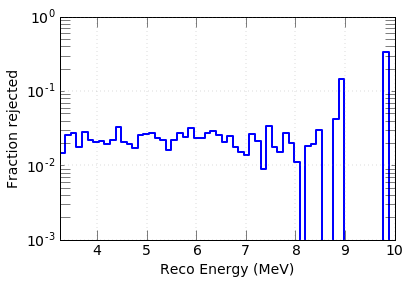

In [61]:
xenergy = np.linspace(3.25, 10, 61)
xcenergy = (xenergy[1:] + xenergy[:-1])/2.
xbeta14 = np.linspace(-0.12,0.95, 31)
xradius = np.linspace(0, .8, 31)
rav = 6000.


rej_histo,x = np.histogram(mc_data['energy'][data_cuts*~tlqpdtcut], xenergy)
all_histo,x = np.histogram(mc_data['energy'][data_cuts], xenergy)
nocuts,x = np.histogram(mc_data['energy'], xenergy)

jplot.unfilledBar(xenergy, rej_histo*1./all_histo)
#plt.ylim(0, 0.1)
#plt.ylim(0.01, 0.)
plt.yscale('log')
plt.ylabel('Fraction rejected')
plt.xlabel('Reco Energy (MeV)')


Diagnostics posr
5.21599035904 4682.31950257 650.390995456


(<matplotlib.figure.Figure at 0x7f60e9be2d50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f60e9578790>)

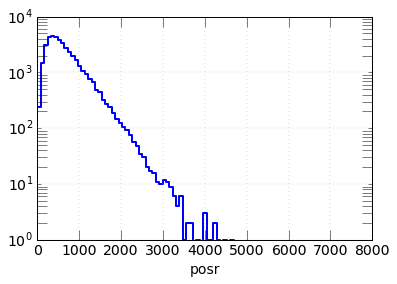

In [62]:
ntuple_tools.arrayDiagnostics(mc_data['posr'][data_cuts], 'posr',ax_lim=[0,8000])